# Decision Trees

Decision trees represent another supervised learning algorithm that can be used for both classification and regression tasks. The algorithm is designed to make a decision about a class label or a value based on a sequence of *decisions* or questions that evaluate to branches in a structure akin to a tree. 

## Entropy
In a binary classification task, we consider $X$ to be a random variable $x\in\{0,1\}$ for all outcomes $x$, sampled from a Bernoulli distribution parameterized by the success rate $p$, i.e., $X\sim\text{Bern}(p)$. This can be expressed as follows.
$$
P(x)=p^x\cdot(1-p)^{1-x}
$$

Given the definition of entropy, the entropy of a Bernoulli distribution can be modelled as
$$
\begin{align*}
H(x)&=-\left[\log\left(p^x\cdot(1-p)^{1-x}\right)\right]\\
&=-\left[x\log(p)+(1-x)\log({1-p})\right]
\end{align*}
$$

## Information Gain
Once the entropy of a distribution is determined, it is necessary to compute the optimality of the split given a particular feature. One criterion for the optimality is quantified as the **information gain**. This quantity is defined as the reduction in the entropy of a distribution by selecting a particular feature as as split.
$$
I^{[l]}_{\text{gain}}=H(p^{[l-1]})-\sum_{i=1}^{m}p^{[l]}_iH(p^{[l]}_i)
$$

# Implementation

In [1]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import classification_report, cohen_kappa_score, roc_auc_score

In [2]:
dataset = pd.read_csv('datasets/titanic_train.csv')
dataset = dataset.loc[:, ~dataset.columns.isin(['Cabin', 'Name', 'PassengerId', 'Ticket'])]
dataset.loc[dataset['Age'].isna(), 'Age'] = dataset['Age'].mean()
dataset.loc[dataset['Embarked'].isna(), 'Embarked'] = dataset['Embarked'].value_counts().idxmax()

dataset['Sex_YN']  = dataset['Sex'].replace({ 'male': 0, 'female': 1 })
dataset['Age_z'] = (dataset['Age'] - dataset['Age'].mean()) / dataset['Age'].std()
dataset['Parch_z'] = (dataset['Parch'] - dataset['Parch'].mean()) / dataset['Parch'].std()
dataset['Fare_z']  = (dataset['Fare'] - dataset['Fare'].mean()) / dataset['Fare'].std()
dataset['Pclass_z']  = (dataset['Pclass'] - dataset['Pclass'].mean()) / dataset['Pclass'].std()

target     = 'Survived'
predictors = [ 'Sex_YN', 'Age_z', 'Parch_z', 'Fare_z', 'Pclass_z']

for label in dataset['Embarked'].unique():
    dataset['Embarked_' + label] = (dataset['Embarked'] == label).replace({ True: 1, False: 0 })
    dataset['Embarked_' + label] = dataset['Embarked_' + label].astype('category')
    predictors.append('Embarked_' + label)
    
#for label in dataset['Pclass'].unique():
#    dataset['Pclass_{}'.format(label)] = (dataset['Pclass'] == label).replace({ True: 1, False: 0 })
#    dataset['Pclass_{}'.format(label)] = dataset['Pclass_{}'.format(label)].astype('category')    
#    predictors.append('Pclass_{}'.format(label))
    
dataset = dataset.loc[:, predictors + [target]]
dataset = dataset.astype({
    'Sex_YN': 'category',
    'Survived': 'category',
})
target_vc = dataset['Survived'].value_counts()
dataset = pd.concat([dataset, dataset[dataset[target] == 1].sample(frac = target_vc[0] / target_vc[1], replace = True, random_state = 0)])
dataset = dataset.iloc[np.random.permutation(len(dataset))].reset_index(drop = True)
dataset

,Sex_YN,Age_z,Parch_z,Fare_z,Pclass_z,Embarked_S,Embarked_C,Embarked_Q,Survived
0,0,1.869009,-0.473408,-0.124850,-0.369158,1,0,0,0
1,0,-0.284503,-0.473408,-0.269990,0.826913,0,1,0,1
2,0,0.000000,-0.473408,-0.648058,-0.369158,1,0,0,0
3,0,0.946075,-0.473408,-0.119064,-1.565228,1,0,0,1
4,0,0.000000,-0.473408,-0.044356,-1.565228,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1435,1,-0.899793,-0.473408,-0.512225,0.826913,0,0,1,0
1436,0,-0.284503,2.007806,-0.234019,0.826913,1,0,0,0
1437,0,-0.822881,0.767199,0.091477,-0.369158,1,0,0,0
1438,0,0.792253,-0.473408,-0.502666,0.826913,0,1,0,0


In [3]:
def binary_cross_entropy_series(p):
    a = pd.Series(p)
    a = a.apply(lambda p : -(p * np.log(p) + (1-p) * np.log(1-p)) if (p > 0.0 and p < 1.0) else 0.0)
    return a

In [4]:
class DecisionNode:
    def __init__(self):
        self.left_child  = None
        self.right_child = None
    
    def find_weighted_entropy(self, data, predictor, target):
        raise NotImplementedError
    
    def find_optimal_split(self, data, predictor, target):
        raise NotImplementedError

class LeafNode(DecisionNode):
    def __init__(self, class_label):
        super().__init__()
        self.class_label = class_label
        
class BinaryDecision(DecisionNode):
    def __init__(self):
        super().__init__()
        
    def find_weighted_entropy(self, data, predictor, target):
        data      = data[[predictor, target]].copy()
        
        # Fraction of target values grouped by predictor values
        pred_grouped  = data.groupby(predictor)[target].value_counts(normalize = True)
        pred_fraction = pred_grouped[(slice(None), 1)]
        pred_entropy  = binary_cross_entropy_series(pred_fraction)
        
        pred_split    = data.groupby(predictor)[target].count()
        pred_split    = pred_split / pred_split.sum()
        
        self.weighted_entropy = np.dot(pred_split, pred_entropy)
        return self.weighted_entropy
        
class NumericDecision(DecisionNode):
    def __init__(self):
        super().__init__()
    
    def find_weighted_entropy(self, data, predictor, target):
        data = data[[predictor, target]].copy()
        data = data.sort_values(by = [predictor], axis = 0, ascending = True).reset_index()
        root_positive_frac = data[target].value_counts(normalize = True)[1]
        data['pct_y_leq']  = (data[target].astype('float64').cumsum() / data.shape[0])
        data['pct_y_g']    = (root_positive_frac - data['pct_y_leq']).astype('float64')
        data['bce_y_leq']  = binary_cross_entropy_series(data['pct_y_leq'])
        data['bce_y_g']    = binary_cross_entropy_series(data['pct_y_g'])
        data['frac_leq']   = pd.Series(np.arange(1, data.shape[0] + 1)) / data.shape[0]
        data['frac_g']     = 1 - data['frac_leq']
        data['weighted_e'] = data['frac_leq'] * data['bce_y_leq'] + data['frac_g'] * data['bce_y_g']
        
        return data
    
    def find_optimal_split(self, data, predictor, target):
        entropy_data   = self.find_weighted_entropy(data, predictor, target)
        self.entropy   = entropy_data.loc[entropy_data['weighted_e'].idxmin(), 'weighted_e']
        self.split_val = entropy_data.loc[entropy_data['weighted_e'].idxmin(), predictor]
        
        return self.split_val, self.entropy

In [5]:
def build_tree(data, predictors, target, curr_depth = 0, max_depth = 12, info_gain_min = 1e-3, entropy_min = 1e-3, min_samples_leaf = 1):
    categorical = [ pred for pred in predictors if pd.api.types.is_categorical_dtype(data[pred]) ]
    numeric     = [ pred for pred in predictors if pd.api.types.is_numeric_dtype(data[pred]) ]
    
    #print(categorical)
    #print(numeric)
    
    parent_entropy = data[target].value_counts(normalize = True)
    parent_entropy = binary_cross_entropy_series(parent_entropy[1])[0]
    entropy_vals   = []
    
    # Calculate entropy for each categorical variable
    test_node = BinaryDecision()
    for category in categorical:
        entropy   = test_node.find_weighted_entropy(data, category, target)
        info_gain = parent_entropy - entropy
        entropy_vals.append({
            'predictor': category,
            'entropy'  : entropy,
            'info_gain': info_gain
        })
    
    # Calculate entropy for each numeric variable
    test_node = NumericDecision()
    for num in numeric:
        split_val, entropy = test_node.find_optimal_split(data, num, target)
        info_gain = parent_entropy - entropy
        entropy_vals.append({
            'predictor': num,
            'entropy'  : entropy,
            'split_val': split_val,
            'info_gain': info_gain
        })
    
    # Choose the optimal split variable with the highest information gain
    optimal_split = max(entropy_vals, key = lambda x : x['info_gain'])
    
    left_split  = None
    right_split = None
    new_node    = None
    if optimal_split['predictor'] in categorical:
        new_node = BinaryDecision()
        new_node.predictor = optimal_split['predictor']
        new_node.entropy   = optimal_split['entropy']
        new_node.info_gain = optimal_split['info_gain']
        
        left_split  = data[data[optimal_split['predictor']] == 0]
        right_split = data[data[optimal_split['predictor']] != 0]
    else:
        new_node = NumericDecision()
        new_node.predictor = optimal_split['predictor']
        new_node.entropy   = optimal_split['entropy']
        new_node.info_gain = optimal_split['info_gain']
        new_node.split_val = optimal_split['split_val']
        
        left_split  = data[data[optimal_split['predictor']] <= new_node.split_val]
        right_split = data[data[optimal_split['predictor']]  > new_node.split_val]
        #print(left_split.shape, right_split.shape)
    
    allowed_to_split    = (curr_depth + 1 < max_depth) and (optimal_split['info_gain'] > info_gain_min)
    has_remaining_data  = (len(left_split) > min_samples_leaf) and (len(right_split) > min_samples_leaf)

    will_continue_split = allowed_to_split and has_remaining_data
    
    # Recursively build the decision tree
    if will_continue_split:
        new_node.left_child  = build_tree(left_split , predictors, target, curr_depth + 1, max_depth)
        new_node.right_child = build_tree(right_split, predictors, target, curr_depth + 1, max_depth)
    else:
        left_class  = left_split[target].value_counts().idxmax()
        right_class = right_split[target].value_counts().idxmax()
        
        new_node.left_child  = LeafNode(left_class)
        new_node.right_child = LeafNode(right_class)
    
    return new_node

def prune_tree(tree):
    if not tree:
        return None
    
    tree.left_child  = prune_tree(tree.left_child)
    tree.right_child = prune_tree(tree.right_child)

    # Remove leaves for which the majority class is the same
    if isinstance(tree.left_child, LeafNode) and isinstance(tree.right_child, LeafNode):
        if tree.left_child.class_label == tree.right_child.class_label:
            return LeafNode(tree.left_child.class_label)
    
    return tree
    
tree = build_tree(dataset, predictors, target, max_depth = 6)
tree = prune_tree(tree)

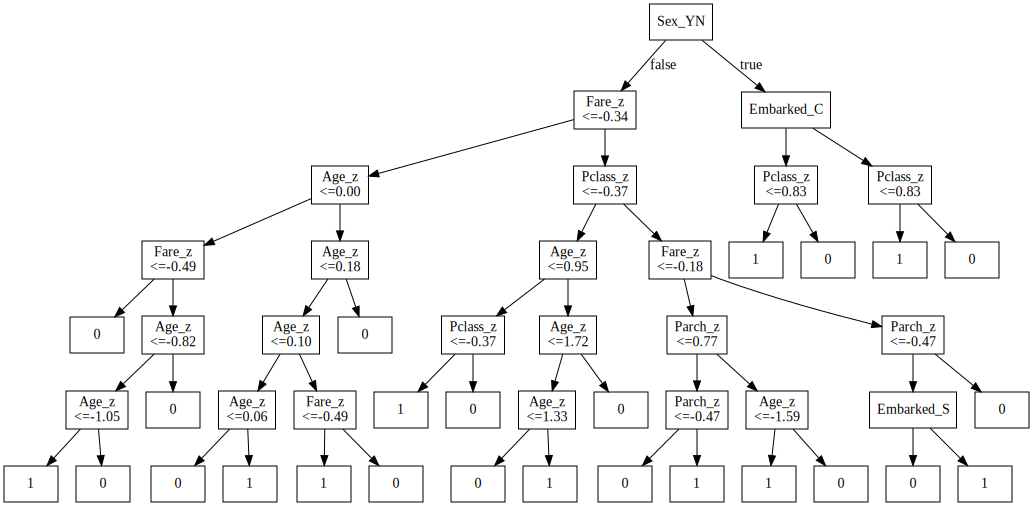

In [6]:
def plot_decision_tree(root, dot, depth = 0):
    global curr_id
    if not root:
        return None
    
    if isinstance(root, NumericDecision):
        node_label = '{}\n<={:.2f}'.format(root.predictor, root.split_val)
    else:
        node_label = root.class_label if isinstance(root, LeafNode) else root.predictor
    
    node_id = '\"{}\"'.format(hash(root))
    dot.node(node_id, '{}'.format(node_label))
    
    left  = plot_decision_tree(root.left_child, dot, depth + 1)
    right = plot_decision_tree(root.right_child, dot, depth + 1)

    if left:  dot.edge(node_id, left , label = 'false' if depth == 0 else '')
    if right: dot.edge(node_id, right, label = 'true' if depth == 0 else '')
    
    return node_id

dot = graphviz.Digraph(comment = 'Decision Tree Plot')
dot.attr('node', shape = 'box', nodesep = '0.1')
plot_decision_tree(tree, dot)
dot

In [7]:
def predict(record, root):
    if isinstance(root, LeafNode):
        return root.class_label
    
    if isinstance(root, NumericDecision):
        if record[root.predictor] <= root.split_val:
            return predict(record, root.left_child)
        else:
            return predict(record, root.right_child)
    elif isinstance(root, BinaryDecision):
        if record[root.predictor] == 0.0:
            return predict(record, root.left_child)
        else:
            return predict(record, root.right_child)

In [8]:
y_pred = []
y_true = dataset[target]

for row in range(dataset.shape[0]):
    x, y = dataset.loc[row, predictors], dataset.loc[row, target]
    y_pred.append(predict(x, tree))
    
y_pred = pd.Series(y_pred, dtype = 'category', name = 'predicted')
print(pd.crosstab(y_pred, y_true))
print()
print(classification_report(y_pred, y_true))
print()
print("Cohen's Kappa: {:.4f}".format(cohen_kappa_score(y_pred, y_true)))

Survived     0    1
predicted          
0          380   83
1          169  808

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       463
           1       0.91      0.83      0.87       977

    accuracy                           0.82      1440
   macro avg       0.80      0.82      0.81      1440
weighted avg       0.84      0.82      0.83      1440


Cohen's Kappa: 0.6176
